In [2]:
library(lmerTest) #lmer with pvalues
library(MuMIn) #R2
library(merTools) #sim
library(dplyr) #%>%
library(boot) #bootstrap IC
library(stringr) #str_c to create henID_WOA

Warning message:
"package 'lmerTest' was built under R version 3.6.3"
Loading required package: lme4

Warning message:
"package 'lme4' was built under R version 3.6.3"
Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 3.6.3"

Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


Warning message:
"package 'MuMIn' was built under R version 3.6.3"
Warning message:
"package 'merTools' was built under R version 3.6.3"
Loading required package: arm

Loading required package: MASS

Warning message:
"package 'MASS' was built under R version 3.6.3"

arm (Version 1.12-2, built: 2021-10-15)


Working directory is C:/Users/camil/Desktop/animals_code/PhD-AnimalWelfare/Chapter1-EarlyMovementLateHealth


Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following object is masked from 'package:MASS':


In [3]:
#install.packages("lmerTest")
#library(lmerTest)

In [4]:
citation("lmerTest")


To cite lmerTest in publications use:

Kuznetsova A, Brockhoff PB, Christensen RHB (2017). "lmerTest Package:
Tests in Linear Mixed Effects Models." _Journal of Statistical
Software_, *82*(13), 1-26. doi: 10.18637/jss.v082.i13 (URL:
https://doi.org/10.18637/jss.v082.i13).

A BibTeX entry for LaTeX users is

  @Article{,
    title = {{lmerTest} Package: Tests in Linear Mixed Effects Models},
    author = {Alexandra Kuznetsova and Per B. Brockhoff and Rune H. B. Christensen},
    journal = {Journal of Statistical Software},
    year = {2017},
    volume = {82},
    number = {13},
    pages = {1--26},
    doi = {10.18637/jss.v082.i13},
  }


library(lme4)
library(arm)
library(MuMIn)
library(tidyverse)
library(plyr)
library(broom)
library(coda)
library(grid)
library(gridExtra)
library(brms)
library(broom.mixed)
library(merTools)
library(tidybayes)
library(parallel)

# Download data

In [5]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'
path_adapt = file.path(path_,'Adaptability')
df = read.csv(file.path(path_adapt,'df_MVT_4individuality_withPCA.csv'), header = TRUE, sep = ",")
df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID) 
df$cDIB = as.integer(df$DIB_startat11)
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment)
#scale: mean-centering of the environmental variable so that intercepts reflect average values for the population and ind. 
df$temperature_C_avg_scale = scale(df$temperature_C_avg, center=TRUE, scale=TRUE)
df$time = scale(df$cDIB, center=FALSE, scale=sd(df$cDIB, na.rm = TRUE)) #as not centering, we need to add this
df$time2 = poly(df$time, degree=2,raw=TRUE)[,2]
df$time3 = poly(df$time, degree=3,raw=TRUE)[,3]
df$avgDIB_scale = scale(df$avgDIB, center=TRUE, scale=TRUE)
df$InitialWeight_scale = scale(df$InitialWeight, center=TRUE, scale=TRUE)

df$WIB = ceiling(df$DIB/7)
#df[c('WIB','DIB')]
df$henID_WOA = str_c(as.character(df$WIB),'_', df$HenID)
#unique(df$henID_WOA)
df$henID_WOA = as.factor(df$henID_WOA)

#setting reference group
contrasts(df$Treatment)
df <- df %>% mutate(Treatment = relevel(Treatment, ref = "TRAN"))
contrasts(df$Treatment)

contrasts(df$CLASS)
df <- df %>% mutate(CLASS = relevel(CLASS, ref = "LEXP"))
contrasts(df$CLASS)

print(dim(df))
summary(df)
head(df,3)

,TRAN
OFH,0
TRAN,1


,OFH
TRAN,0
OFH,1


,MEXP,REXP
LEXP,0,0
MEXP,1,0
REXP,0,1


,MEXP,REXP
LEXP,0,0
MEXP,1,0
REXP,0,1


[1] 3230   35


     HenID           DIB         CLASS          PenID     temperature_C_avg
 hen_116:  43   Min.   :11.00   LEXP: 965   pen10  :504   Min.   : 4.000   
 hen_124:  43   1st Qu.:23.00   MEXP:1379   pen11  :504   1st Qu.: 8.667   
 hen_127:  43   Median :33.00   REXP: 886   pen8   :430   Median :11.000   
 hen_136:  43   Mean   :33.59               pen9   :429   Mean   :10.838   
 hen_147:  43   3rd Qu.:44.00               pen4   :388   3rd Qu.:12.667   
 hen_151:  43   Max.   :54.00               pen5   :363   Max.   :19.333   
 (Other):2972                               (Other):612                    
  tobeusedPCA     InitialWeight  Treatment   perc_duration_5_Zone
 Min.   :0.0000   Min.   :1046   TRAN:1616   Min.   :  0.00      
 1st Qu.:0.0000   1st Qu.:1130   OFH :1614   1st Qu.: 11.00      
 Median :0.0000   Median :1164               Median : 33.00      
 Mean   :0.1734   Mean   :1169               Mean   : 39.21      
 3rd Qu.:0.0000   3rd Qu.:1200               3rd Qu.: 66.00   

,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,PC1,cDIB,temperature_C_avg_scale,time,time2,time3,avgDIB_scale,InitialWeight_scale,WIB,henID_WOA
,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<int>,<int>,...,<dbl>,<int>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<fct>
1,hen_134,11,MEXP,pen10,11.50000,1,1112,TRAN,100,0,...,-1.738433,0,0.2080966,0.0000000,0.000000000,0.0000000000,-0.3677554,-0.9142959,2,2_hen_134
2,hen_134,12,MEXP,pen10,10.16667,0,1112,TRAN,86,0,...,-1.455477,1,-0.2112122,0.0811546,0.006586069,0.0005344898,-0.3677554,-0.9142959,2,2_hen_134
3,hen_134,13,MEXP,pen10,9.00000,0,1112,TRAN,100,0,...,-1.738433,2,-0.5781073,0.1623092,0.026344277,0.0042759186,-0.3677554,-0.9142959,2,2_hen_134


In [6]:
sd(df$avgDIB_scale)

[1] 1

In [7]:
sd(df$time)

[1] 1

In [8]:
sd(df$time2)

[1] 3.729153

In [9]:
sd(df$PC1)

[1] 0.9747003

In [10]:
length(unique(df[['HenID']]))

[1] 80

# Random Intercept

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
PC1 ~ time + time2 + avgDIB_scale + Treatment + CLASS + temperature_C_avg_scale +  
    InitialWeight_scale + (1 | PenID/HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  6942.2   7015.2  -3459.1   6918.2     3218 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0852 -0.5944  0.0099  0.6232  3.9027 

Random effects:
 Groups      Name        Variance Std.Dev.
 HenID:PenID (Intercept) 0.343942 0.58647 
 PenID       (Intercept) 0.006704 0.08188 
 Residual                0.457636 0.67649 
Number of obs: 3230, groups:  HenID:PenID, 80; PenID, 8

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -0.75936    0.15368   34.90867  -4.941 1.93e-05 ***
time                       1.06415    0.05194 3150.30803  20.487  < 2e-16 ***
time2                     -0.23692    0.01444 3150.34043 -

Warning message:
"'r.squaredGLMM' now calculates a revised statistic. See the help page."


R2m,R2c
0.1510067,0.5193136


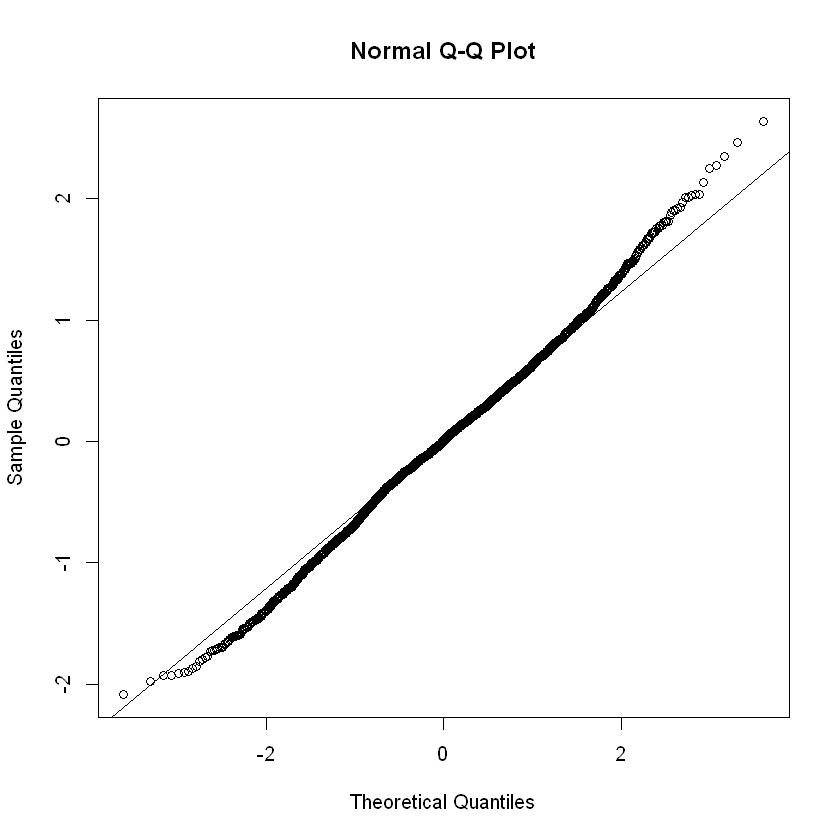

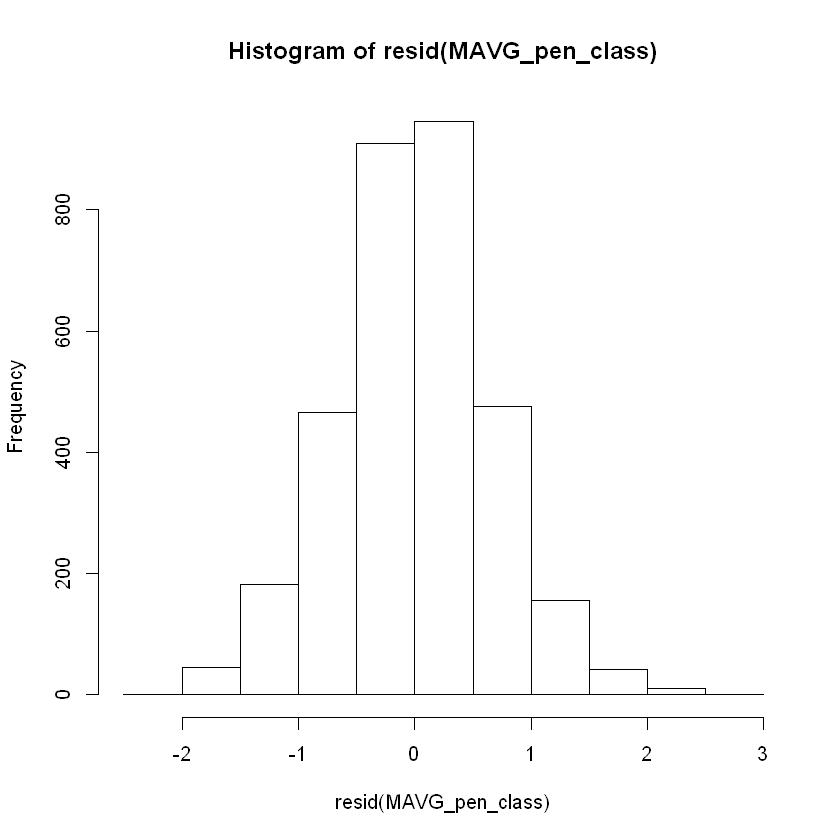

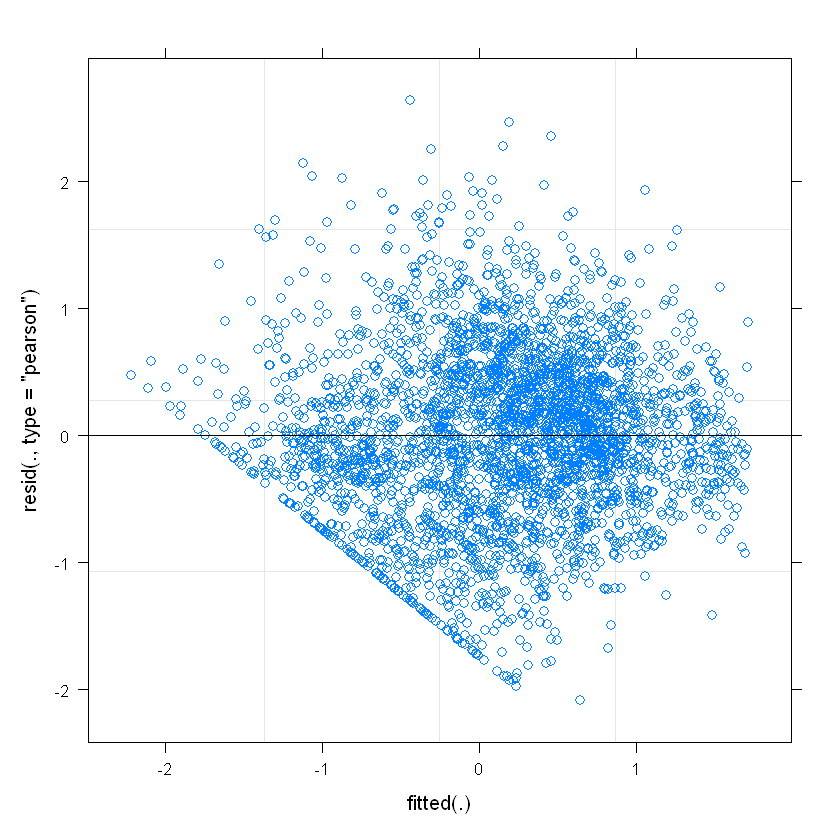

In [11]:
MAVG_pen_class = lmerTest::lmer(PC1 ~ time + time2 + avgDIB_scale + Treatment + CLASS + temperature_C_avg_scale + InitialWeight_scale + (1|PenID/HenID), REML=FALSE, data = df)
summary(MAVG_pen_class)
r.squaredGLMM(MAVG_pen_class)
###### normally distributed residuals
qqnorm(resid(MAVG_pen_class))
qqline(resid(MAVG_pen_class))
hist(resid(MAVG_pen_class))
######check homogeneity of variance (residuals has constant variance)
plot(MAVG_pen_class)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale +  
    InitialWeight_scale + (1 | PenID/HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  6941.4   7002.2  -3460.7   6921.4     3220 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0862 -0.5986  0.0097  0.6252  3.8943 

Random effects:
 Groups      Name        Variance Std.Dev.
 HenID:PenID (Intercept) 0.361906 0.60159 
 PenID       (Intercept) 0.002797 0.05289 
 Residual                0.457637 0.67649 
Number of obs: 3230, groups:  HenID:PenID, 80; PenID, 8

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -0.60729    0.10877   12.25039  -5.583 0.000111 ***
time                       1.06420    0.05194 3150.30994  20.488  < 2e-16 ***
time2                     -0.23694    0.01444 3150.34429 -16.406  

R2m,R2c
0.1352048,0.5187367


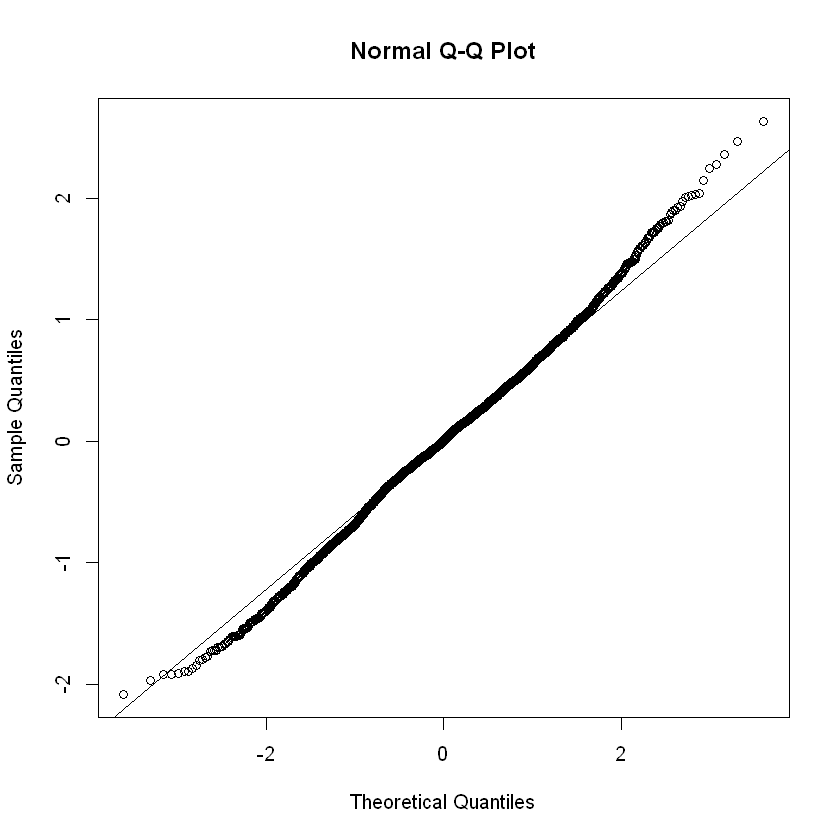

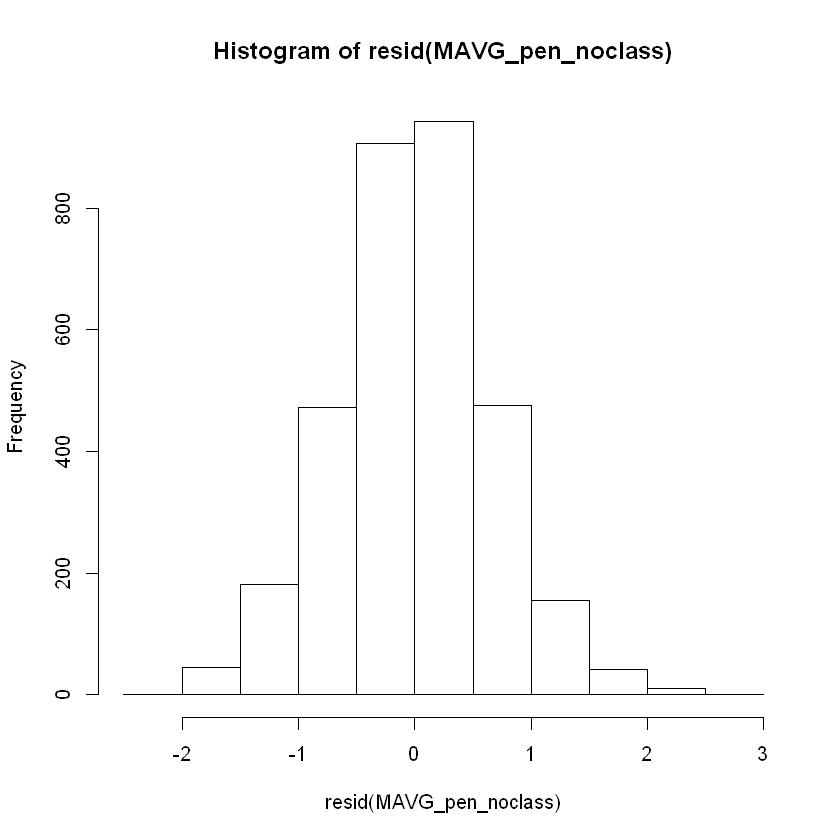

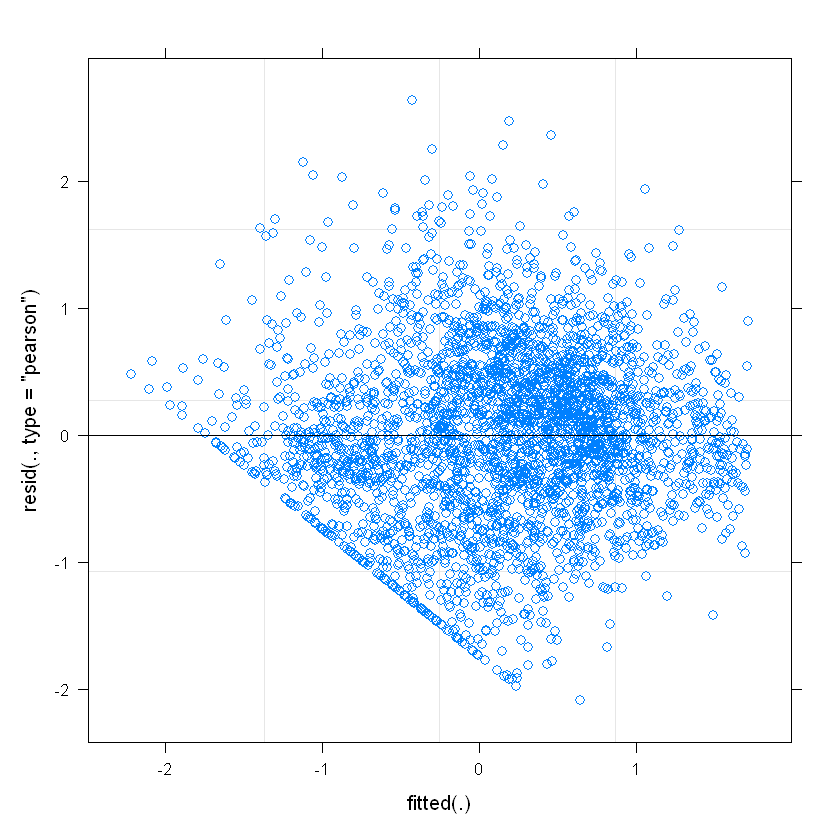

In [13]:
MAVG_pen_noclass = lmerTest::lmer(PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale + InitialWeight_scale + (1|PenID/HenID), REML=FALSE, data = df)
summary(MAVG_pen_noclass)
r.squaredGLMM(MAVG_pen_noclass)
###### normally distributed residuals
qqnorm(resid(MAVG_pen_noclass))
qqline(resid(MAVG_pen_noclass))
hist(resid(MAVG_pen_noclass))
######check homogeneity of variance (residuals has constant variance)
plot(MAVG_pen_noclass)

In [34]:
0.002797 /(0.002797 +0.361906  +0.457637  ) *100

[1] 0.340127

In [15]:
anova(MAVG_pen_class, MAVG_pen_noclass, Test='Chisq')

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAVG_pen_noclass,10,6941.384,7002.186,-3460.692,6921.384,NA,NA,NA
MAVG_pen_class,12,6942.234,7015.197,-3459.117,6918.234,3.150075,2,0.2069998


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
PC1 ~ time + time2 + avgDIB_scale + Treatment + CLASS + temperature_C_avg_scale +  
    InitialWeight_scale + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  6940.4   7007.2  -3459.2   6918.4     3219 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0828 -0.5950  0.0099  0.6247  3.9010 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3507   0.5922  
 Residual             0.4576   0.6765  
Number of obs: 3230, groups:  HenID, 80

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -0.76147    0.14913   91.04982  -5.106 1.79e-06 ***
time                       1.06420    0.05194 3150.36043  20.488  < 2e-16 ***
time2                     -0.23694    0.01444 3150.39919 -16.406  < 2e-16 ***
avgDIB_scale               0.05524    0.06752   80.075

R2m,R2c
0.1492194,0.5183358


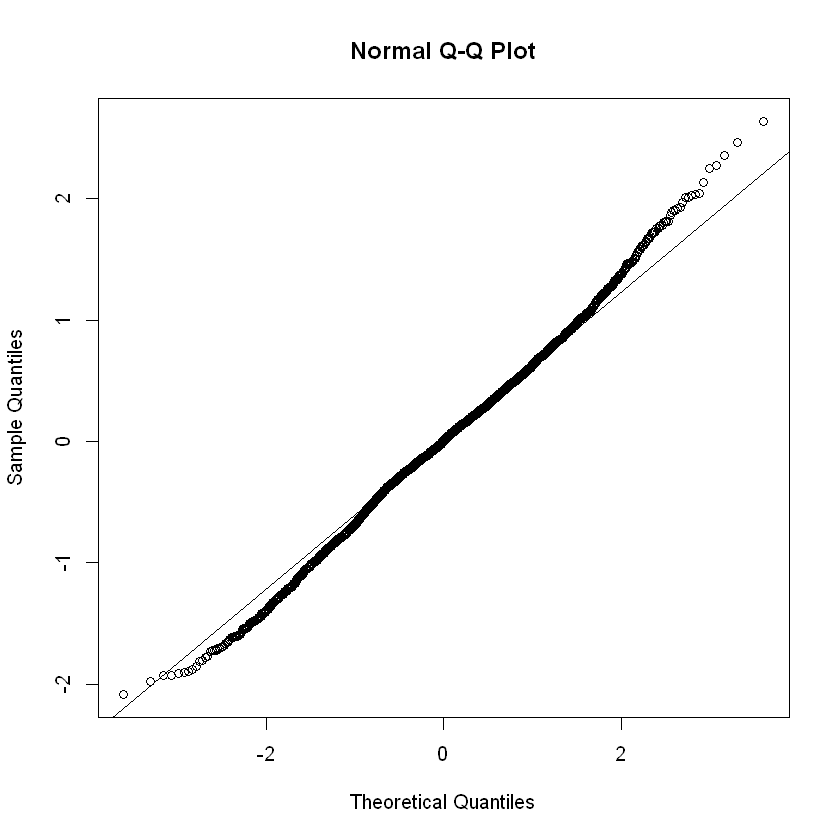

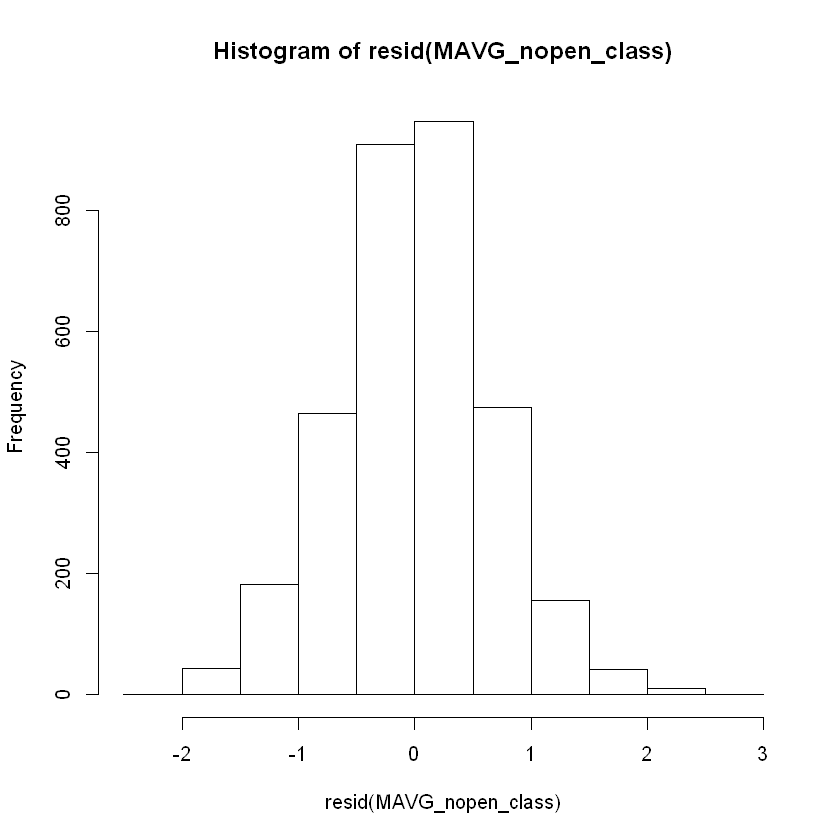

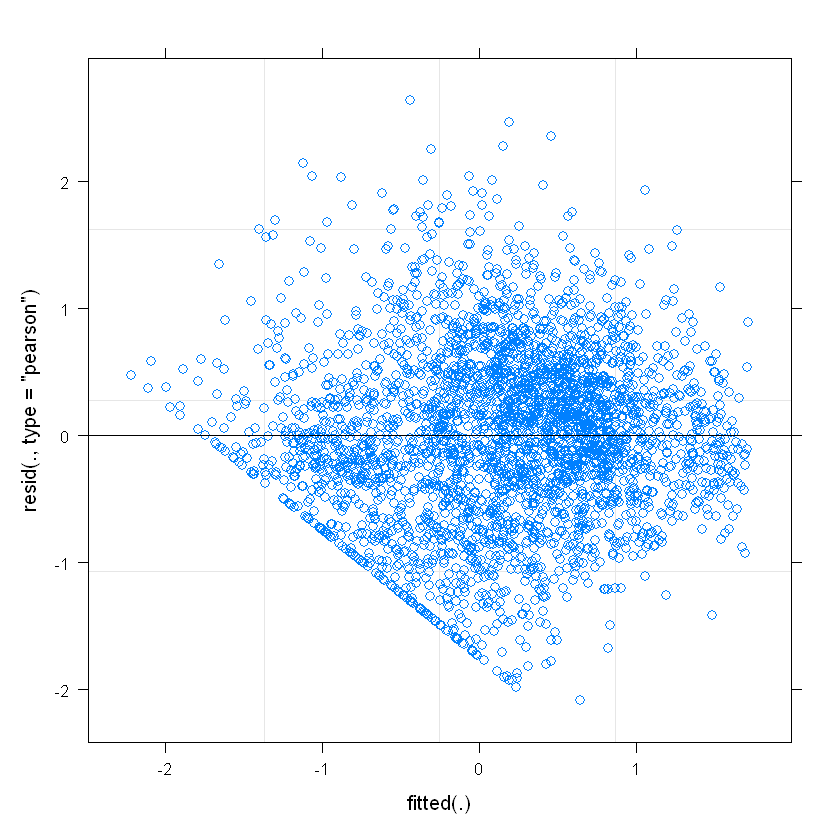

In [16]:
MAVG_nopen_class = lmerTest::lmer(PC1 ~ time + time2 + avgDIB_scale + Treatment + CLASS + temperature_C_avg_scale + InitialWeight_scale + (1|HenID), REML=FALSE, data = df)
summary(MAVG_nopen_class)
r.squaredGLMM(MAVG_nopen_class)
###### normally distributed residuals
qqnorm(resid(MAVG_nopen_class))
qqline(resid(MAVG_nopen_class))
hist(resid(MAVG_nopen_class))
######check homogeneity of variance (residuals has constant variance)
plot(MAVG_nopen_class)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale +  
    InitialWeight_scale + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  6939.4   6994.1  -3460.7   6921.4     3221 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0850 -0.5990  0.0092  0.6250  3.8937 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3647   0.6039  
 Residual             0.4576   0.6765  
Number of obs: 3230, groups:  HenID, 80

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -0.60731    0.10575  104.23784  -5.743 9.27e-08 ***
time                       1.06422    0.05194 3150.33361  20.489  < 2e-16 ***
time2                     -0.23694    0.01444 3150.37103 -16.406  < 2e-16 ***
avgDIB_scale               0.05577    0.06874   80.05755   0.8

R2m,R2c
0.1345959,0.5184085


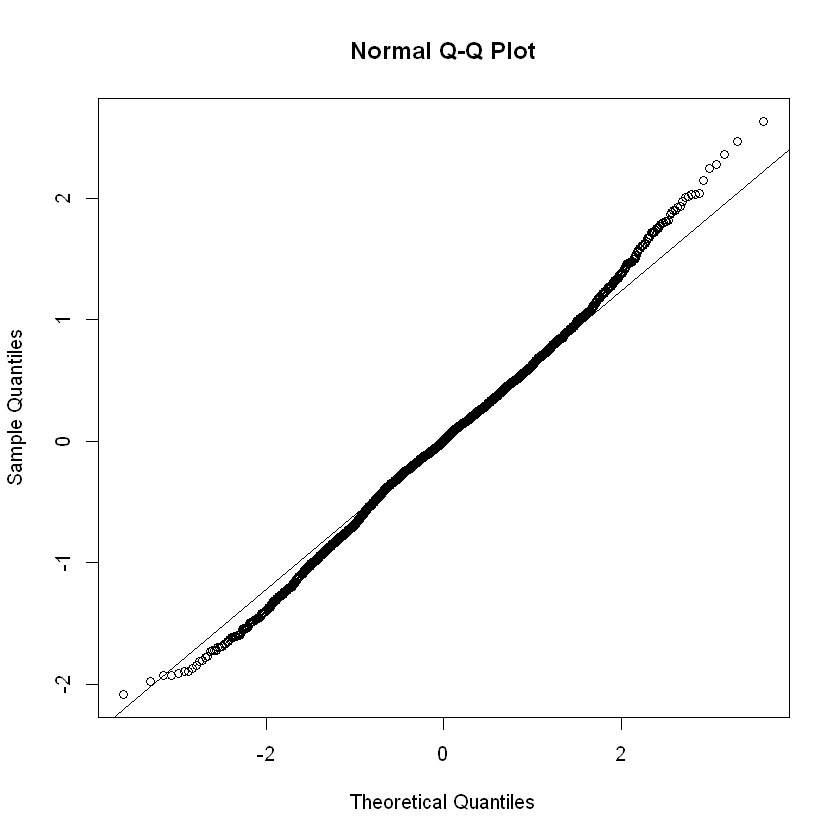

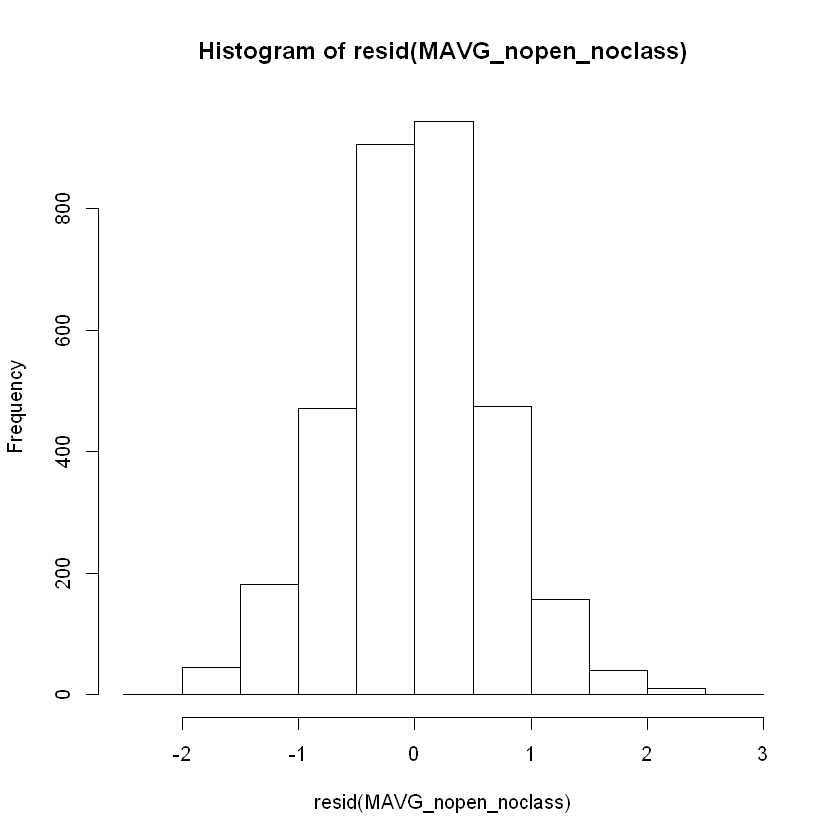

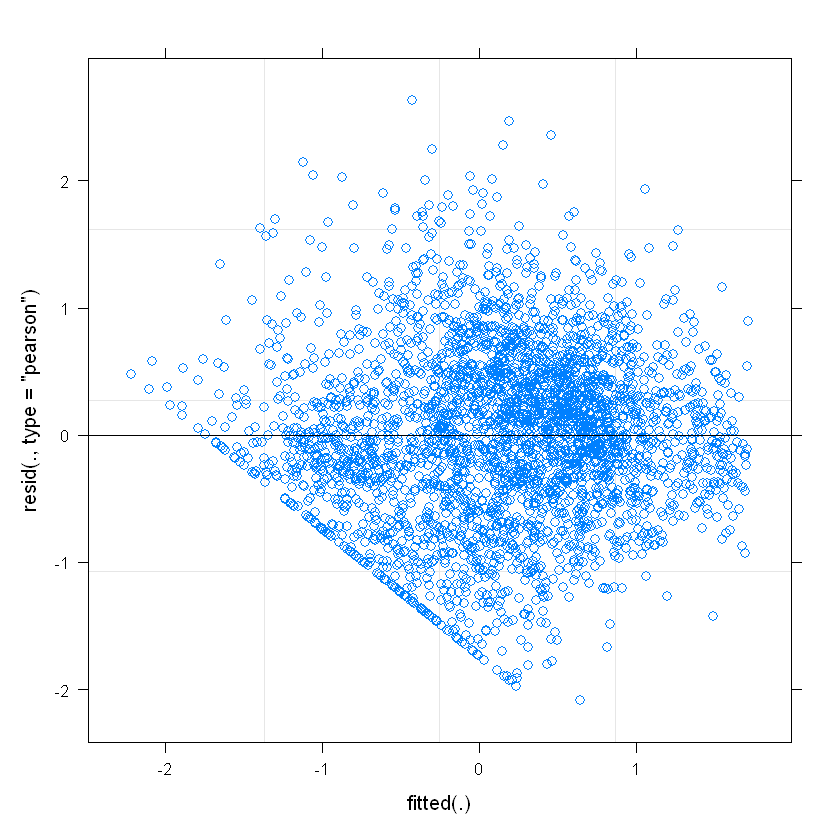

In [17]:
MAVG_nopen_noclass = lmerTest::lmer(PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale + InitialWeight_scale + (1|HenID), REML=FALSE, data = df)
summary(MAVG_nopen_noclass)
r.squaredGLMM(MAVG_nopen_noclass)
###### normally distributed residuals
qqnorm(resid(MAVG_nopen_noclass))
qqline(resid(MAVG_nopen_noclass))
hist(resid(MAVG_nopen_noclass))
######check homogeneity of variance (residuals has constant variance)
plot(MAVG_nopen_noclass)

In [18]:
anova(MAVG_nopen_class, MAVG_nopen_noclass, Test='Chisq')

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAVG_nopen_noclass,9,6939.407,6994.129,-3460.704,6921.407,NA,NA,NA
MAVG_nopen_class,11,6940.361,7007.243,-3459.180,6918.361,3.046477,2,0.2180047


# Repeatabilities

In [19]:
summary(MAVG_nopen_noclass)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: 
PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale +  
    InitialWeight_scale + (1 | HenID)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  6939.4   6994.1  -3460.7   6921.4     3221 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0850 -0.5990  0.0092  0.6250  3.8937 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3647   0.6039  
 Residual             0.4576   0.6765  
Number of obs: 3230, groups:  HenID, 80

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -0.60731    0.10575  104.23784  -5.743 9.27e-08 ***
time                       1.06422    0.05194 3150.33361  20.489  < 2e-16 ***
time2                     -0.23694    0.01444 3150.37103 -16.406  < 2e-16 ***
avgDIB_scale               0.05577    0.06874   80.05755   0.8

In [20]:
anova(MAVG_nopen_noclass)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
time,192.1092849,192.1092849,1,3150.33361,419.7849397,1.106298e-87
time2,123.1836378,123.1836378,1,3150.37103,269.1730179,4.132918e-58
avgDIB_scale,0.3012748,0.3012748,1,80.05755,0.6583265,4.195572e-01
Treatment,2.3627545,2.3627545,1,80.00792,5.1629402,2.575804e-02
temperature_C_avg_scale,1.7397143,1.7397143,1,3150.25893,3.8015127,5.129491e-02
InitialWeight_scale,0.2955856,0.2955856,1,80.01039,0.6458949,4.239655e-01


In [1]:
0.36472 /(0.36472 + 0.45764)

[1] 0.4435041

In [21]:
print(VarCorr(MAVG_nopen_noclass),comp =c("Variance","Std.Dev."))
rep = VarCorr(MAVG_nopen_noclass)$"HenID"[1]/
(VarCorr(MAVG_nopen_noclass)$"HenID"[1]+
 attr(VarCorr(MAVG_nopen_noclass), "sc")^2) # sd^2 = equal to the variance of residual
#alternatively: 0.36472/(0.36472+0.45764)
rep

#or with posterior distribtion with 1000 simulations and credible interval
set.seed(1)
simulated = sim(MAVG_nopen_noclass, n.sim = 1000)
posterior_HenID = apply(simulated@ranef$"HenID"[ , , 1],1,var)
posterior_residual  = simulated@sigma^2
quantile(posterior_HenID/
         (posterior_HenID+posterior_residual), prob=c(0.025, 0.5, 0.975))

 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.36472  0.60392 
 Residual             0.45764  0.67649 


[1] 0.4435068

2.5%       50%     97.5% 
0.4300289 0.4532784 0.4797883

# Short and long term Repeatabilities

In [22]:
model_ = lmerTest::lmer(PC1 ~ time + time2 + avgDIB_scale + Treatment + CLASS + temperature_C_avg_scale + InitialWeight_scale + (1|HenID/henID_WOA), REML=FALSE, data = df)

print(VarCorr(model_),comp =c("Variance","Std.Dev."))

#LT
rep = VarCorr(model_)$"HenID"[1]/
(VarCorr(model_)$"HenID"[1]+ attr(VarCorr(model_), "sc")^2 + VarCorr(model_)$"henID_WOA:HenID"[1]) 
rep

#ST
rep = (VarCorr(model_)$"HenID"[1] + VarCorr(model_)$"henID_WOA:HenID"[1])/
(VarCorr(model_)$"HenID"[1]+ attr(VarCorr(model_), "sc")^2 + VarCorr(model_)$"henID_WOA:HenID"[1]) 
rep

#with posterior distribtion with 1000 simulations and credible interval
set.seed(1)
simulated = sim(model_, n.sim = 1000)
posterior_HenID = apply(simulated@ranef$"HenID"[ , , 1],1,var)
posterior_HenIDWOA = apply(simulated@ranef$"henID_WOA:HenID"[ , , 1],1,var)
posterior_residual  = simulated@sigma^2
quantile(posterior_HenID/
         (posterior_HenID+posterior_residual+posterior_HenIDWOA), prob=c(0.025, 0.5, 0.975))
quantile((posterior_HenID+posterior_HenIDWOA)/
         (posterior_HenID+posterior_residual+posterior_HenIDWOA), prob=c(0.025, 0.5, 0.975))

 Groups          Name        Variance Std.Dev.
 henID_WOA:HenID (Intercept) 0.32452  0.56967 
 HenID           (Intercept) 0.30928  0.55613 
 Residual                    0.18792  0.43349 


[1] 0.3763849

[1] 0.7713123

2.5%       50%     97.5% 
0.3447922 0.3899765 0.4442352

2.5%       50%     97.5% 
0.7573910 0.7763510 0.7981055

# Plasticity

### first order

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale +  
    InitialWeight_scale + (1 + time | HenID)
   Data: df

REML criterion at convergence: 5870.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6631 -0.5933 -0.0186  0.5689  4.5306 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 HenID    (Intercept) 1.0358   1.0177        
          time        0.1554   0.3942   -0.79
 Residual             0.3005   0.5482        
Number of obs: 3230, groups:  HenID, 80

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -0.63492    0.13890  109.49435  -4.571 1.28e-05 ***
time                       1.09239    0.06116  261.50537  17.860  < 2e-16 ***
time2                     -0.24346    0.01176 3071.39261 -20.700  < 2e-16 ***
avgDIB_scale               0.06161    0.07018   75.98983   0.

R2m,R2c
0.1391946,0.694731


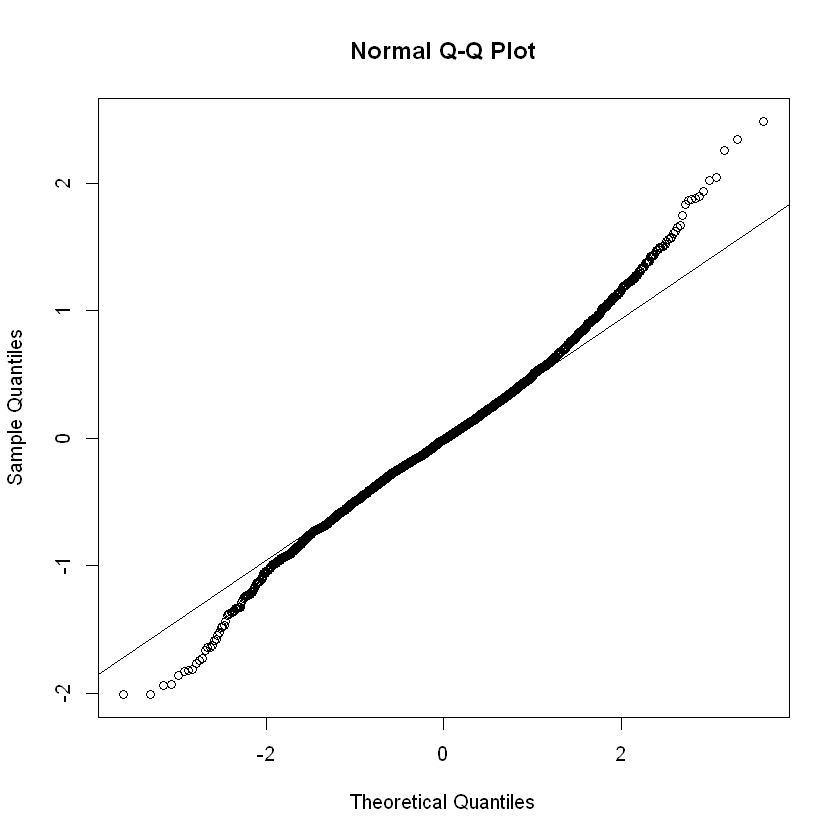

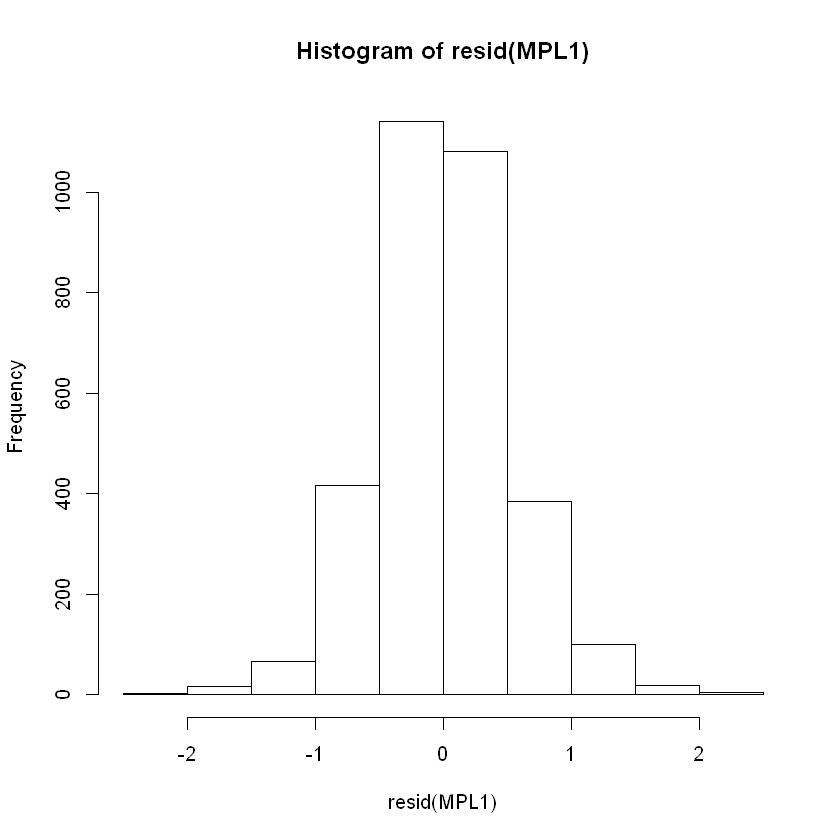

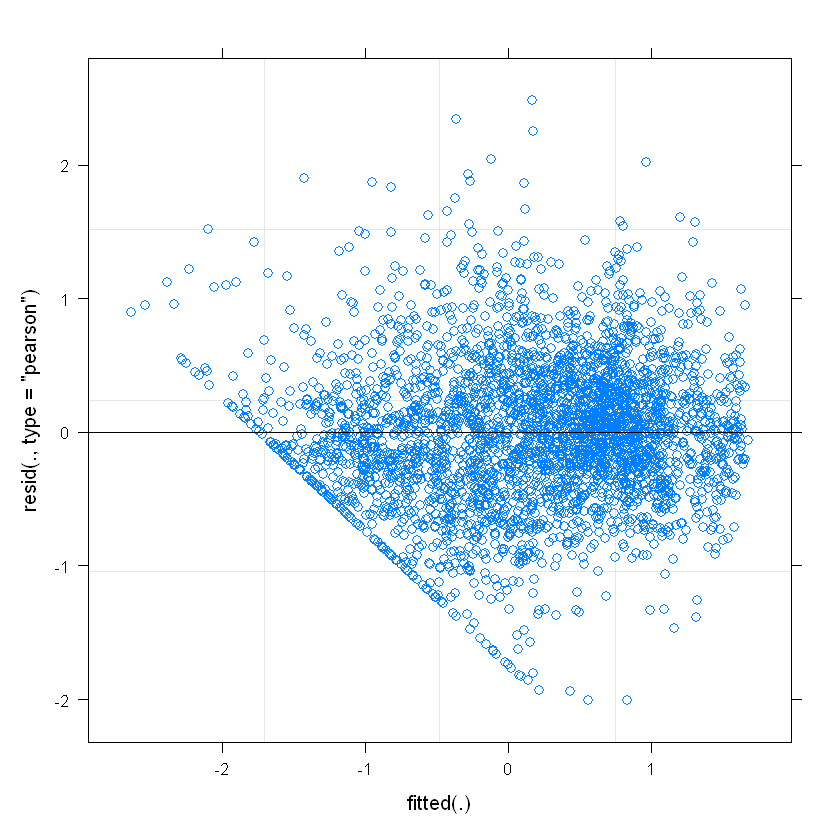

In [23]:
#random interecepts and slopes over DIB for each animal (interactio between DIB and henID as a random effect)
MPL1 = lmer(PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale + InitialWeight_scale + (1 + time|HenID), 
                REML=TRUE, data=df) #, control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
summary(MPL1)
r.squaredGLMM(MPL1)
###### normally distributed residuals
qqnorm(resid(MPL1))
qqline(resid(MPL1))
hist(resid(MPL1))
######check homogeneity of variance (residuals has constant variance)
plot(MPL1)

In [24]:
ranef_vals = data.frame(VarCorr(MPL1))
ranef_vals
ranef_vals$sdcor[3]

grp,var1,var2,vcov,sdcor
<chr>,<chr>,<chr>,<dbl>,<dbl>
HenID,(Intercept),NA,1.0357617,1.0177238
HenID,time,NA,0.1553986,0.3942063
HenID,(Intercept),time,-0.3181374,-0.7929782
Residual,NA,NA,0.3005260,0.5482025


[1] -0.7929782

Loading required namespace: optimx




ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df, statistic = li_CORR, R = 300, formula = PC1 ~ 
    time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale + 
        InitialWeight_scale + (1 + time | HenID))


Bootstrap Statistics :
      original      bias    std. error
t1* -0.7929755 -0.00634922  0.01003476

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 300 bootstrap replicates

CALL : 
boot.ci(boot.out = output, type = "perc")

Intervals : 
Level     Percentile     
95%   (-0.818, -0.777 )  
Calculations and Intervals on Original Scale
Some percentile intervals may be unstable

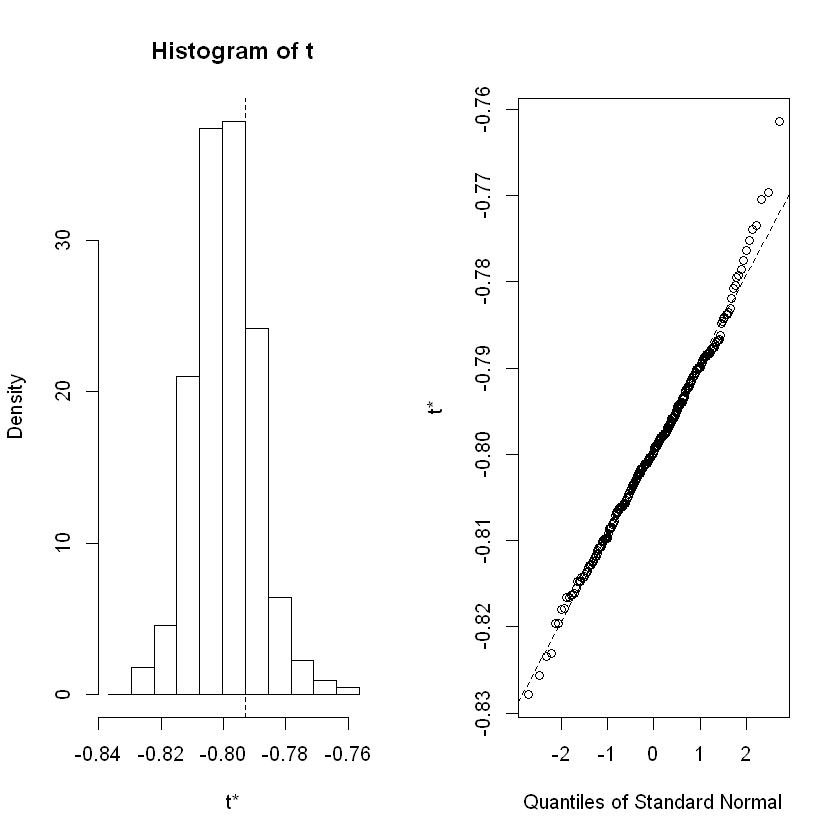

In [25]:
# creating Function to obtain R-Squared from the data
li_CORR <- function(formula, data, indices) {
    val <- data[indices,] # selecting sample with boot 
    mod_ = lmer(formula, REML=TRUE, data=val, control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
    ranef_vals = data.frame(VarCorr(mod_))
    return(ranef_vals$sdcor[3])
} 
# Performing 1500 replications with boot 
#R: nbr of bootstrap replicates.
#statistic: The function should include an indices parameter that the boot() function can use to select cases for each 
#replication
set.seed(1)
#we can add the parameters that has to be passed to the function that produces the statistic of interest, in this case: formula
output <- boot(data=df, statistic=li_CORR, R=300, formula=PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale + InitialWeight_scale + (1 + time|HenID))
output
# Plotting the output 
plot(output)

# Obtaining a confidence interval of 95%
boot.ci(output, type="perc")

In [26]:
confint(MPL1, oldNames=FALSE)

Computing profile confidence intervals ...



,2.5 %,97.5 %
sd_(Intercept)|HenID,0.85948370,1.190041958
cor_time.(Intercept)|HenID,-0.86797694,-0.698490149
sd_time|HenID,0.33511132,0.464260292
sigma,0.53459700,0.562022873
(Intercept),-0.90542279,-0.365071535
time,0.97252948,1.212300050
time2,-0.26650750,-0.220403661
avgDIB_scale,-0.07445843,0.197672889
TreatmentOFH,-0.58841466,-0.037201038
temperature_C_avg_scale,-0.05009538,-0.005925275


### second order

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale +  
    InitialWeight_scale + (1 + time + time2 | HenID)
   Data: df
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 5561.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2055 -0.5846 -0.0197  0.5667  4.5113 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 HenID    (Intercept) 1.25024  1.1181              
          time        0.79363  0.8909   -0.69      
          time2       0.04675  0.2162    0.41 -0.89
 Residual             0.25836  0.5083              
Number of obs: 3230, groups:  HenID, 80

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -0.66875    0.14764  100.98302  -4.530 1.62e-05 ***
time                       1.11954    0.10728   82.3711

R2m,R2c
0.1360266,0.737207


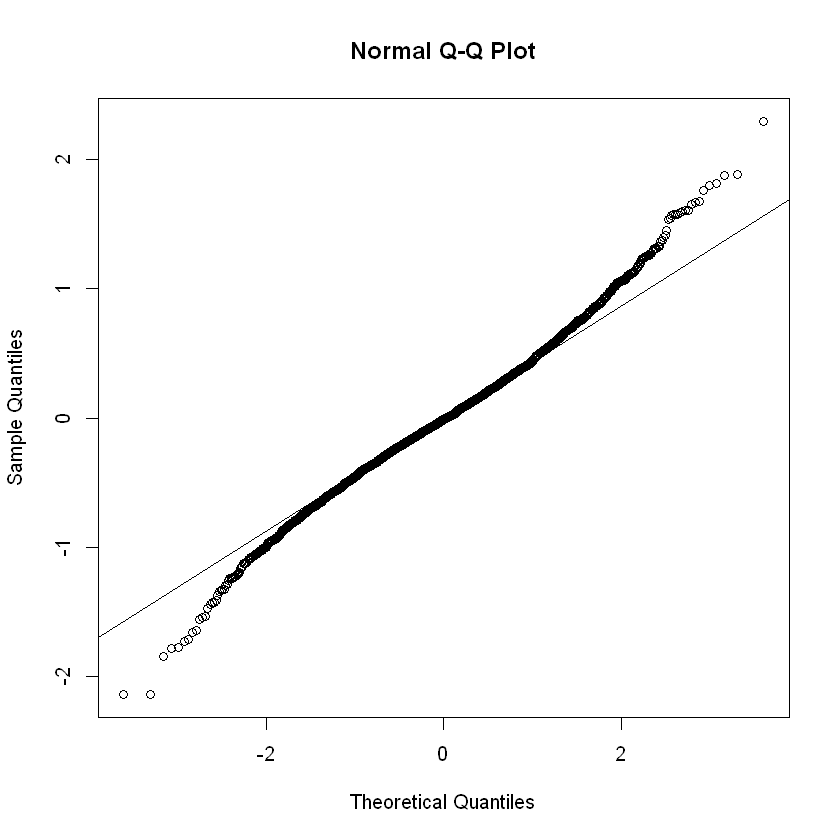

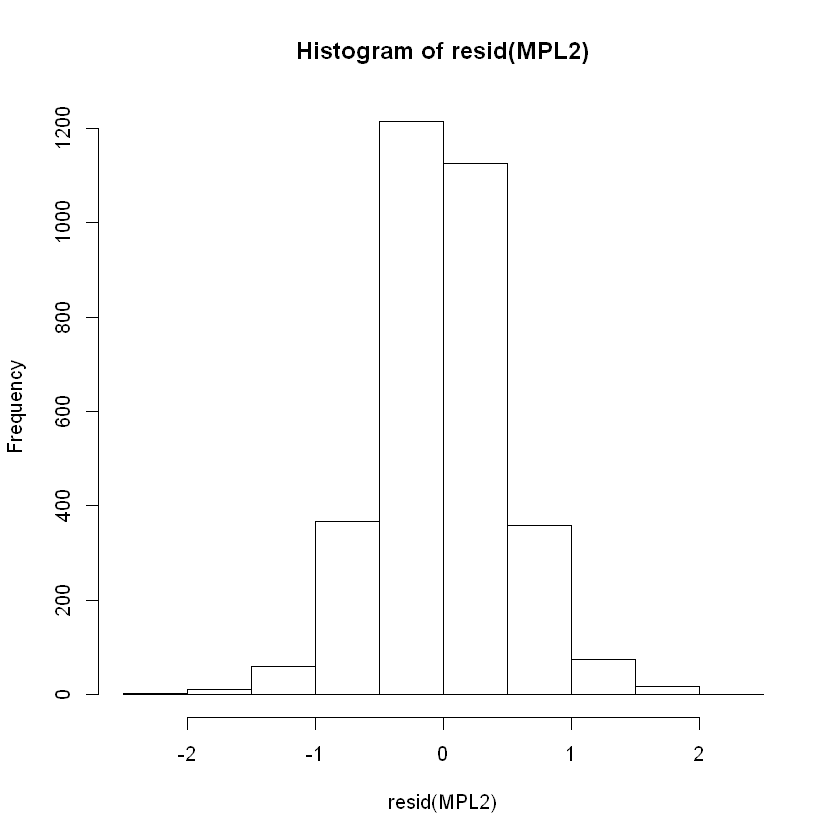

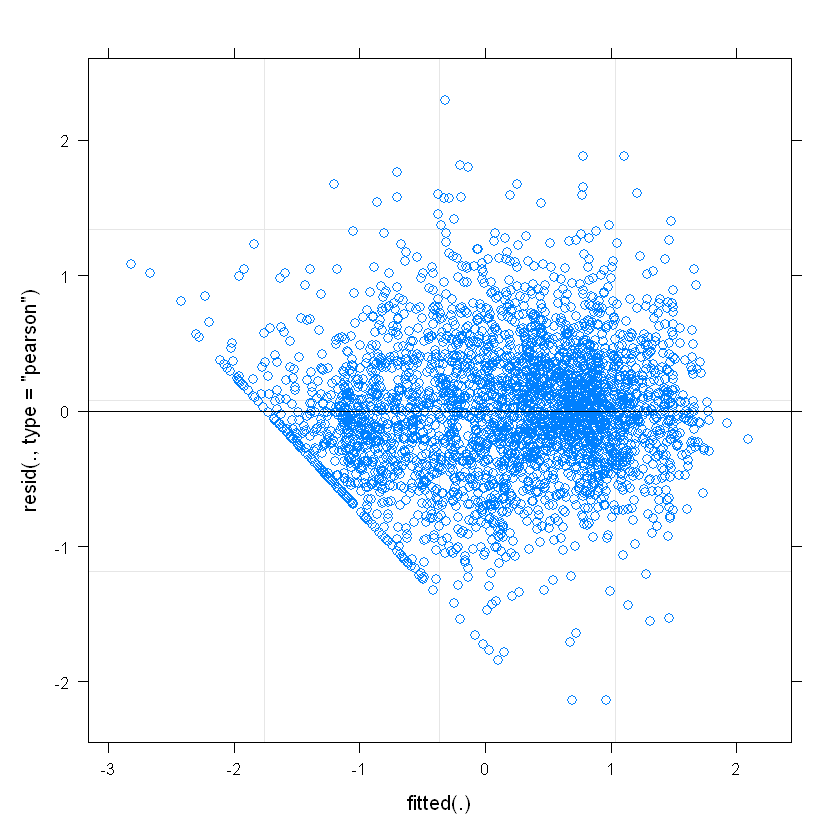

In [27]:
#test whether a nonlinear random slope over DIB improve model fit
#https://stat.ethz.ch/pipermail/r-sig-mixed-models/2008q2/000918.html
MPL2 = lmer(PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale + InitialWeight_scale + (1 + time + time2|HenID), 
                REML=TRUE, data=df, control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
summary(MPL2)
r.squaredGLMM(MPL2)
###### normally distributed residuals
qqnorm(resid(MPL2))
qqline(resid(MPL2))
hist(resid(MPL2))
######check homogeneity of variance (residuals has constant variance)
plot(MPL2)

In [28]:
#https://www.rdocumentation.org/packages/lme4/versions/1.1-26/topics/confint.merMod
#confint(MPL2, oldNames=FALSE, method = "profile") 


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df, statistic = li_CORR, R = 300, formula = PC1 ~ 
    time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale + 
        InitialWeight_scale + (1 + time + time2 | HenID))


Bootstrap Statistics :
      original      bias    std. error
t1* -0.6884144 -0.03018331  0.02550931
t2*  0.4052987  0.05698391  0.04389513
t3* -0.8944362 -0.01415219  0.01016759

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 300 bootstrap replicates

CALL : 
boot.ci(boot.out = output, type = "perc", index = 1)

Intervals : 
Level     Percentile     
95%   (-0.7606, -0.6640 )  
Calculations and Intervals on Original Scale
Some percentile intervals may be unstable

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 300 bootstrap replicates

CALL : 
boot.ci(boot.out = output, type = "perc", index = 2)

Intervals : 
Level     Percentile     
95%   ( 0.3681,  0.5391 )  
Calculations and Intervals on Original Scale
Some percentile intervals may be unstable

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 300 bootstrap replicates

CALL : 
boot.ci(boot.out = output, type = "perc", index = 3)

Intervals : 
Level     Percentile     
95%   (-0.9266, -0.8867 )  
Calculations and Intervals on Original Scale
Some percentile intervals may be unstable

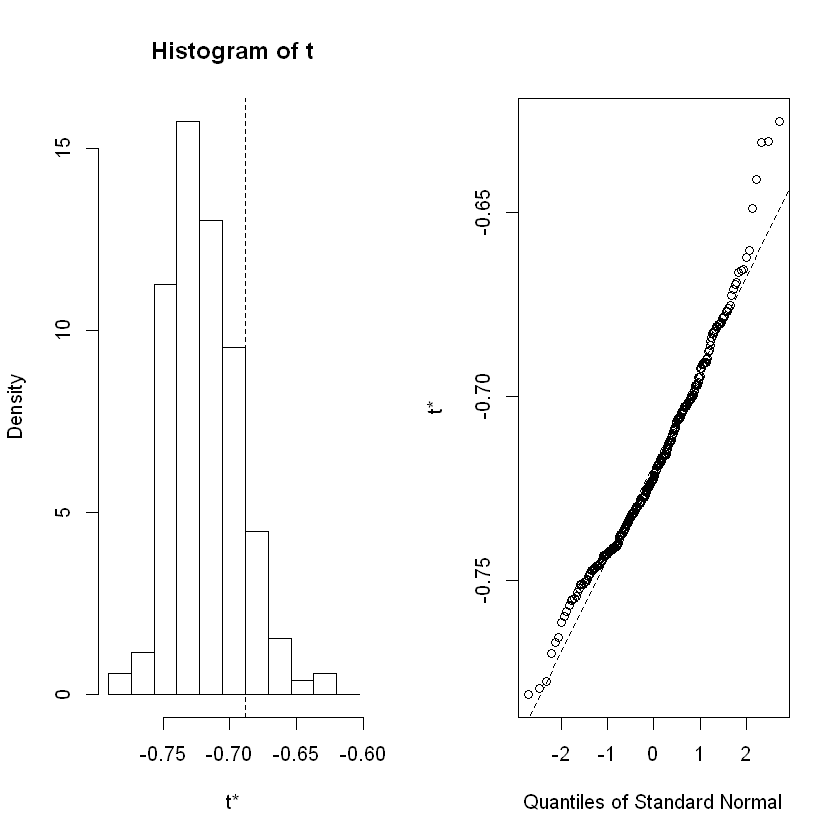

In [29]:
# Creating Function to obtain R-Squared from the data
li_CORR <- function(formula, data, indices) {
    val <- data[indices,] # selecting sample with boot 
    mod_ = lmer(formula, REML=TRUE, data=val, control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
    ranef_vals = data.frame(VarCorr(mod_))
    return(c(ranef_vals$sdcor[4], ranef_vals$sdcor[5],ranef_vals$sdcor[6]))
    #return(ranef_vals$sdcor[4])
} 
# Performing 1500 replications with boot 
#R: nbr of bootstrap replicates.
#statistic: The function should include an indices parameter that the boot() function can use to select cases for each 
#replication
set.seed(1)
#we can add the parameters that has to be passed to the function that produces the statistic of interest, in this case: formula
output <- boot(data=df, statistic=li_CORR, R=300, formula=PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale + InitialWeight_scale + (1 + time + time2|HenID))
output
# Plotting the output 
plot(output)

# Obtaining a confidence interval of 95%
boot.ci(output, type="perc", index=1)
boot.ci(output, type="perc", index=2)
boot.ci(output, type="perc", index=3)

In [30]:
ranef_vals = data.frame(VarCorr(MPL2))
ranef_vals
ranef_vals$sdcor[4]#intercept time
ranef_vals$sdcor[5]#intercept time2
ranef_vals$sdcor[6]#time time2

grp,var1,var2,vcov,sdcor
<chr>,<chr>,<chr>,<dbl>,<dbl>
HenID,(Intercept),NA,1.25023987,1.1181413
HenID,time,NA,0.79362560,0.8908567
HenID,time2,NA,0.04674971,0.2162168
HenID,(Intercept),time,-0.68573205,-0.6884144
HenID,(Intercept),time2,0.09798539,0.4052987
HenID,time,time2,-0.17228469,-0.8944362
Residual,NA,NA,0.25835531,0.5082866


[1] -0.6884144

[1] 0.4052987

[1] -0.8944362

### third order

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
PC1 ~ time + time2 + time3 + avgDIB_scale + Treatment + temperature_C_avg_scale +  
    InitialWeight_scale + (1 + time + time2 | HenID)
   Data: df
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 5568.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2104 -0.5814 -0.0178  0.5628  4.4951 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 HenID    (Intercept) 1.25130  1.1186              
          time        0.79449  0.8913   -0.69      
          time2       0.04679  0.2163    0.41 -0.89
 Residual             0.25839  0.5083              
Number of obs: 3230, groups:  HenID, 80

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             -6.848e-01  1.495e-01  1.059e+02  -4.581 1.27e-05 ***
time                     1.173e+00  1.324e-01  

R2m,R2c
0.1360992,0.7372506


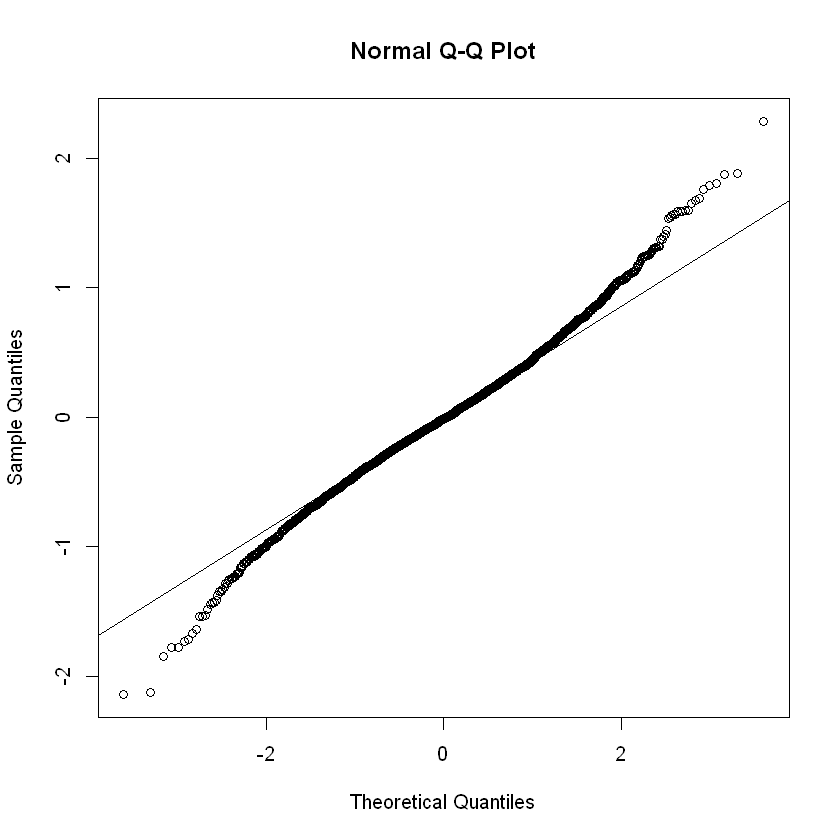

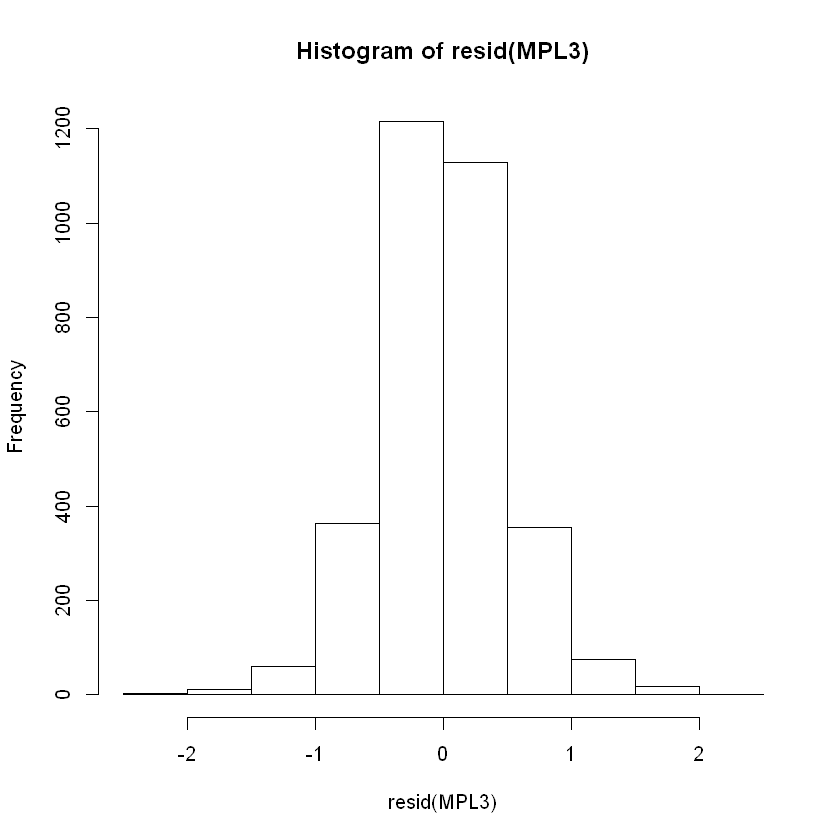

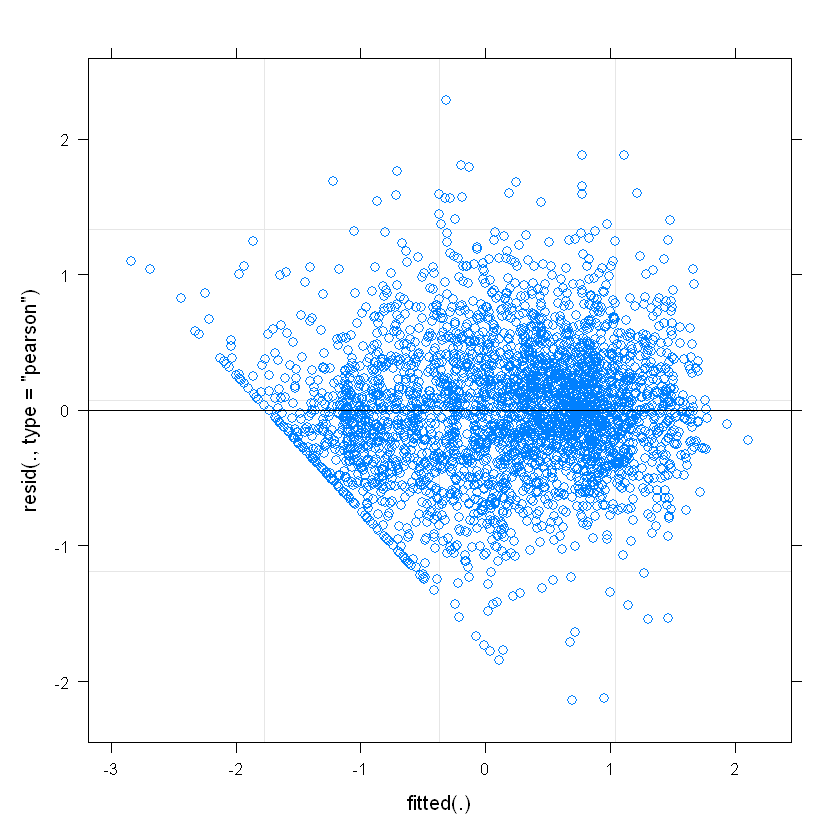

In [31]:
#test whether a nonlinear random slope over DIB improve model fit
MPL3 = lmer(PC1 ~ time + time2 + time3 + avgDIB_scale + Treatment + temperature_C_avg_scale + InitialWeight_scale + (1 + time + time2|HenID), 
                REML=TRUE, data=df, control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
summary(MPL3)
r.squaredGLMM(MPL3)
###### normally distributed residuals
qqnorm(resid(MPL3))
qqline(resid(MPL3))
hist(resid(MPL3))
######check homogeneity of variance (residuals has constant variance)
plot(MPL3)

## Comparing models

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale +  
    InitialWeight_scale + (1 | HenID)
   Data: df

REML criterion at convergence: 6954.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0846 -0.5988  0.0091  0.6238  3.8914 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.3845   0.6201  
 Residual             0.4581   0.6768  
Number of obs: 3230, groups:  HenID, 80

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -0.60730    0.10817   97.82941  -5.614 1.85e-07 ***
time                       1.06421    0.05197 3147.31629  20.479  < 2e-16 ***
time2                     -0.23694    0.01445 3147.35186 -16.398  < 2e-16 ***
avgDIB_scale               0.05577    0.07052   76.05190   0.791   0.4315    
TreatmentOFH              -0.31706    0.14316   76.007

R2m,R2c
0.1317943,0.5279932


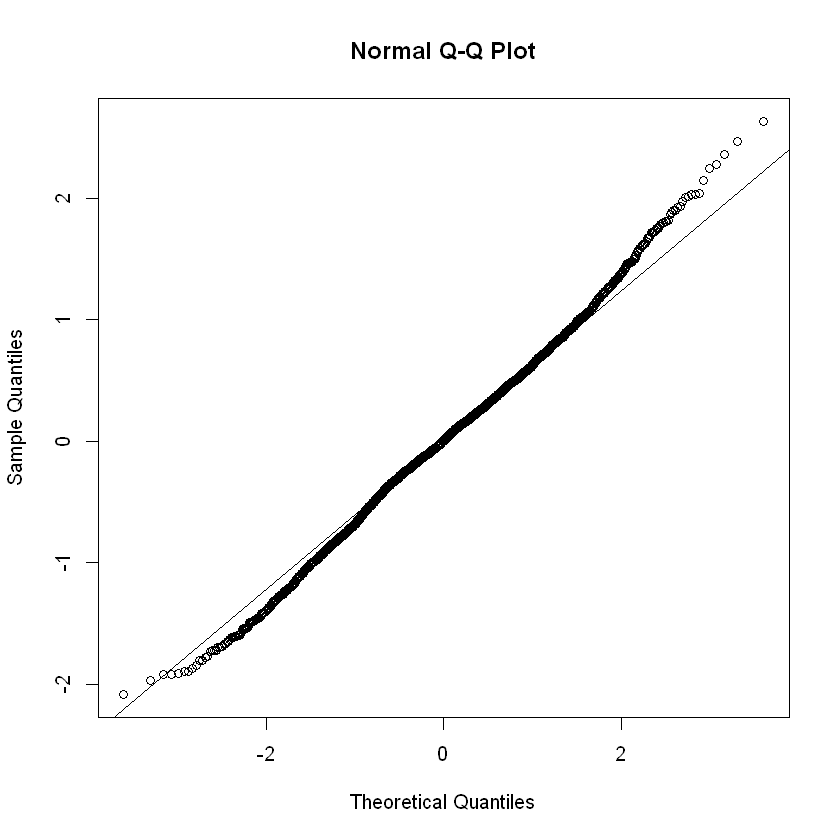

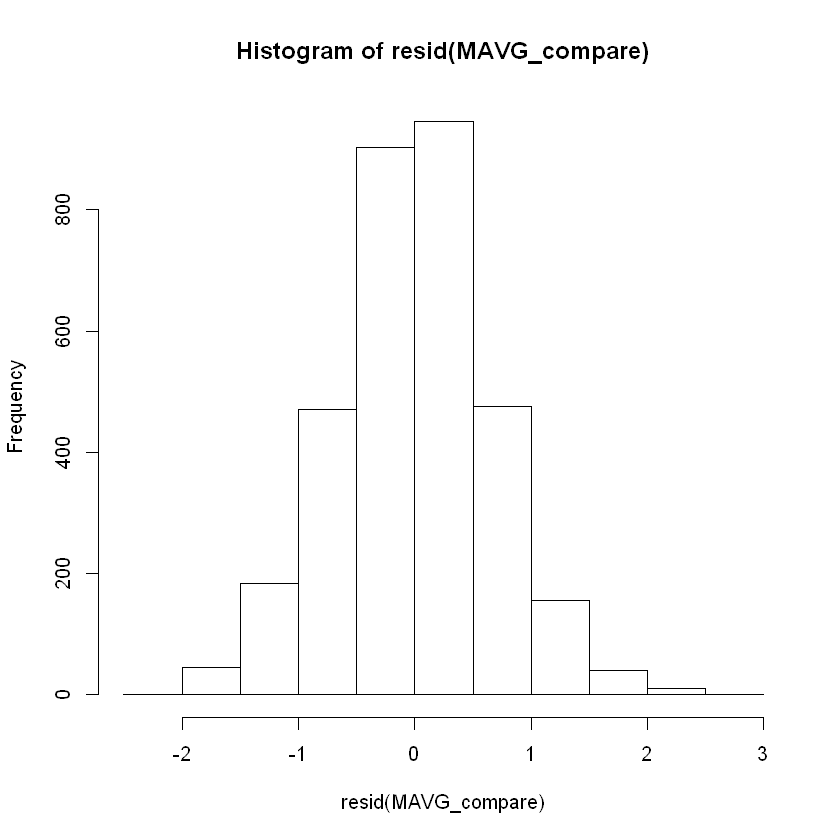

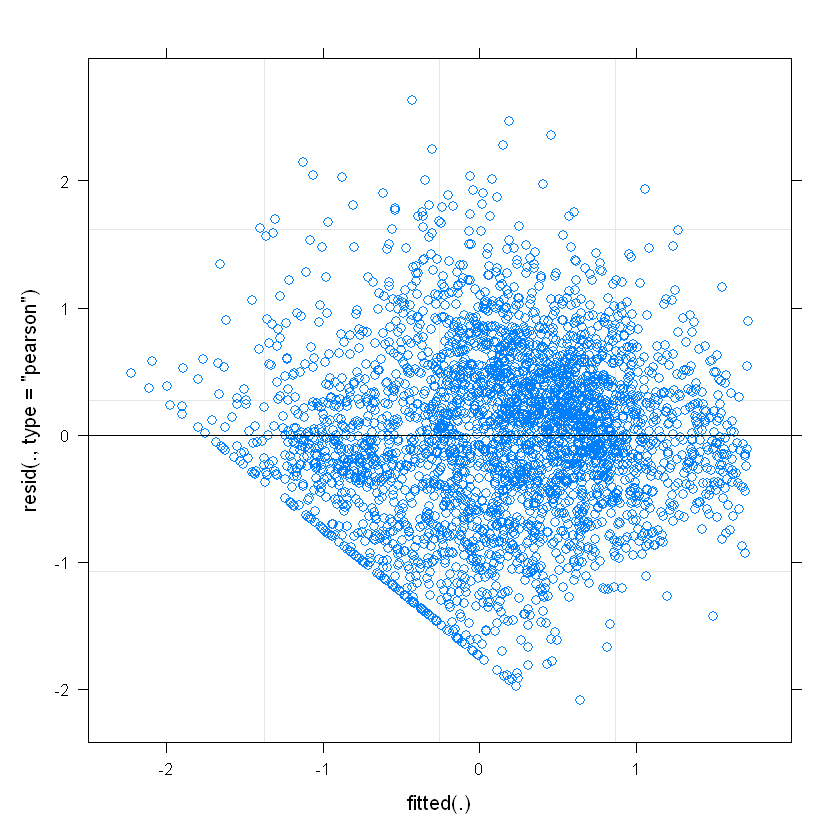

In [32]:
#to compare with: RI same as previously selected but with RELM = TRUE, beause two models with nested random structures cannot 
#be done with ML as the estimators for the variance terms are biased under ML 
MAVG_compare = lmerTest::lmer(PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale + InitialWeight_scale + (1|HenID), REML=TRUE, data = df)
summary(MAVG_compare)
r.squaredGLMM(MAVG_compare)
###### normally distributed residuals
qqnorm(resid(MAVG_compare))
qqline(resid(MAVG_compare))
hist(resid(MAVG_compare))
######check homogeneity of variance (residuals has constant variance)
plot(MAVG_compare)

In [33]:
AIC(MAVG_compare, MPL1, MPL2, MPL3)

,df,AIC
,<dbl>,<dbl>
MAVG_compare,9,6972.565
MPL1,11,5892.547
MPL2,14,5589.740
MPL3,15,5598.526


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale +  
    InitialWeight_scale + (1 + time + time2 | HenID)
   Data: df
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 5561.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2055 -0.5846 -0.0197  0.5667  4.5113 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 HenID    (Intercept) 1.25024  1.1181              
          time        0.79363  0.8909   -0.69      
          time2       0.04675  0.2162    0.41 -0.89
 Residual             0.25836  0.5083              
Number of obs: 3230, groups:  HenID, 80

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               -0.66875    0.14764  100.98302  -4.530 1.62e-05 ***
time                       1.11954    0.10728   82.3711

R2m,R2c
0.1360266,0.737207


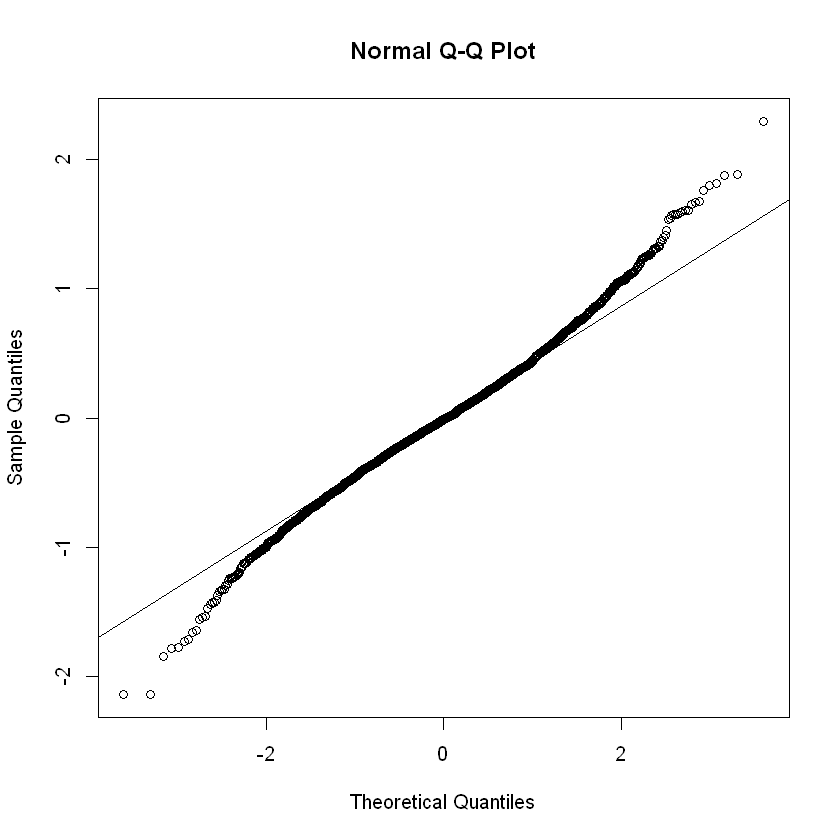

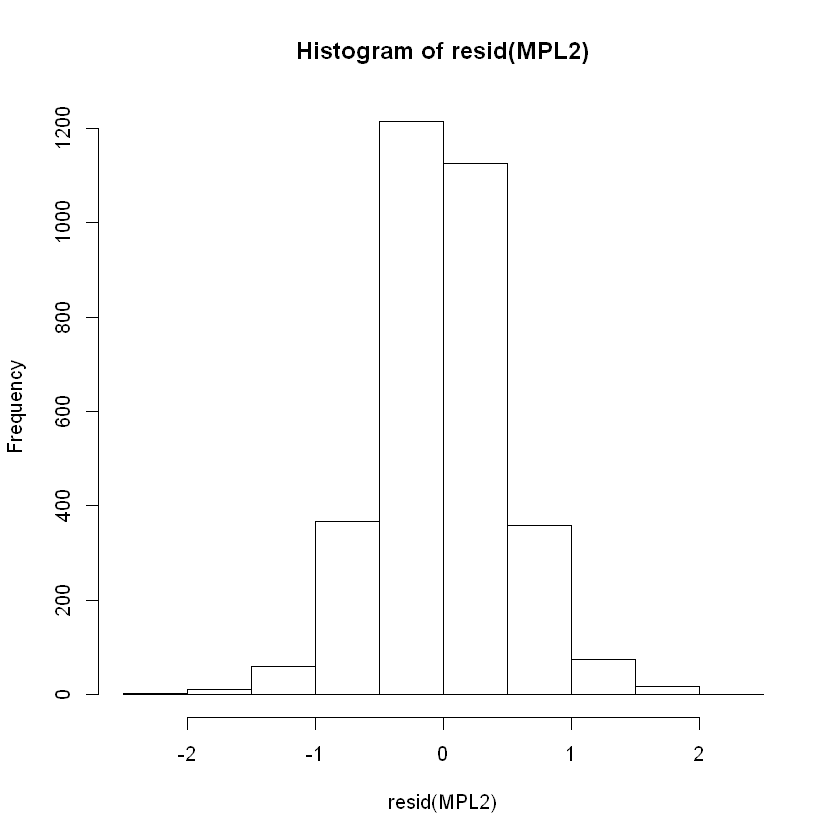

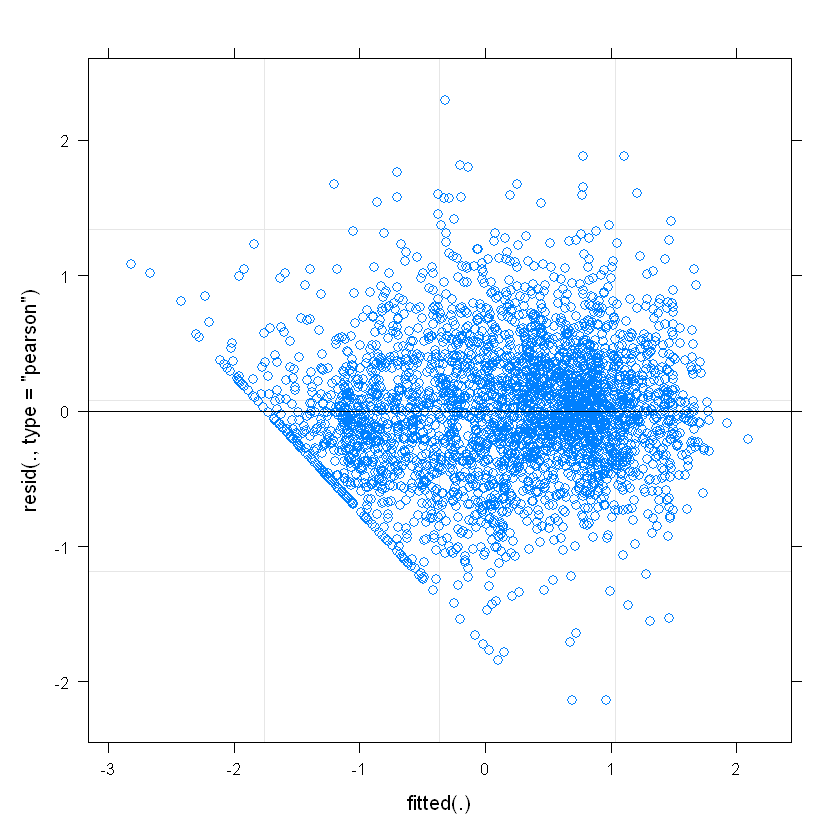

In [38]:
#test whether a nonlinear random slope over DIB improve model fit
#https://stat.ethz.ch/pipermail/r-sig-mixed-models/2008q2/000918.html
MPL2_test = lmer(PC1 ~ time + time2 + avgDIB_scale + Treatment + temperature_C_avg_scale + InitialWeight_scale + (1+time+time2|HenID), 
                REML=TRUE, data=df, control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
summary(MPL2)
r.squaredGLMM(MPL2)
###### normally distributed residuals
qqnorm(resid(MPL2))
qqline(resid(MPL2))
hist(resid(MPL2))
######check homogeneity of variance (residuals has constant variance)
plot(MPL2)

In [36]:
AIC(MAVG_compare, MPL1, MPL2, MPL3, MPL2_test)

,df,AIC
,<dbl>,<dbl>
MAVG_compare,9,6972.565
MPL1,11,5892.547
MPL2,14,5589.740
MPL3,15,5598.526
MPL2_test,14,5702.295


In [49]:
#LRT from anova is not correct anymore as we compare parameters that are on the boundery (random effects)
#LRT MAVG_compare and MPL1 (i.e. compare  model with the random intercept and the model with random intercept and slope)
#Same as the citation https://link.springer.com/content/pdf/10.1007%2F978-0-387-87458-6_5.pdf (chapter 5 of the book)
#summary(MAVG_nopen_noclass)$logLik
#summary(MPL1)$logLik
AIC(MAVG_compare, MPL1)
L = -2*(summary(MAVG_compare)$logLik -summary(MPL1)$logLik)
pval = 0.5 * ((1 - pchisq(L, df=1)) + (1 - pchisq(L, df=2))) #1-pchisq to have the right side of the curve
pval
#if p-value < 0.001. reject H0, This means that adding random slope to the model is a significant improvement

,df,AIC
,<dbl>,<dbl>
MAVG_compare,9,6972.565
MPL1,11,5892.547


'log Lik.' 0 (df=9)

In [51]:
anova(MAVG_compare,MPL1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAVG_compare,9,6939.407,6994.129,-3460.704,6921.407,NA,NA,NA
MPL1,11,5861.176,5928.059,-2919.588,5839.176,1082.231,2,9.920125e-236


In [42]:
anova(MAVG_compare,MPL1,MPL2)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAVG_compare,9,6939.407,6994.129,-3460.704,6921.407,NA,NA,NA
MPL1,11,5861.176,5928.059,-2919.588,5839.176,1082.2310,2,9.920125e-236
MPL2,14,5560.007,5645.131,-2766.004,5532.007,307.1686,3,2.793936e-66


In [ ]:
#number of parameters: covariates between random effects!
#http://www.bristol.ac.uk/cmm/learning/videos/random-slopes.html
#https://stats.stackexchange.com/questions/180230/number-of-parameters-in-mixed-model

In [43]:
#p.23 of supplements of the guide provided in the paper as citation: Arnold, P. A., Kruuk, L. E. B. & Nicotra, A. B. 
#How to analyse plant phenotypic plasticity in response to a changing climate. New Phytologist 222, 1235–1241 (2019).
chi2 = 2*(summary(MPL2)$logLik -summary(MPL1)$logLik) #p.23
(1-pchisq(chi2, 3))

'log Lik.' 0 (df=14)

In [64]:
#or same as formula as before give same results too:
L = -2*(summary(MPL1)$logLik -summary(MPL2)$logLik)
pval = 0.5 * ((1 - pchisq(L, df=2)) + (1 - pchisq(L, df=3))) 
pval

'log Lik.' 0 (df=11)

# Save BLUPS estimates

In [32]:
#BLUP intercepts: behavioural type individual estiamtes with mer-Tools (obtaining repeated samples from the posterior distribution
#of the model from which we can calculate the stdev for each individual)
#as PC1 is not interpretable as much as "total distance travelled" would, we wont add the population-level estimate
#done in "studing..."
#as for our purpose it wont change anything
set.seed(1)
simulated_individualbehaviouraltype = REsim(MAVG_nopen_noclass, n.sims = 1000)
head(simulated_individualbehaviouraltype,3)
write.csv(simulated_individualbehaviouraltype,file.path(path_adapt,'BLUP_RI.csv'),row.names = FALSE)

,groupFctr,groupID,term,mean,median,sd
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,HenID,hen_10,(Intercept),-0.4629900,-0.4578683,0.1929582
2,HenID,hen_101,(Intercept),0.5049087,0.5040936,0.1863260
3,HenID,hen_102,(Intercept),-1.3716680,-1.3654082,0.1701152


In [33]:
#BLUP: individual estimates with uncertainty values
set.seed(1)
#REsim already synthesis results compare to the sim(). I verified manually
simulated_individualplasticity = REsim(MPL2, n.sim = 1000)
head(simulated_individualplasticity,3)
write.csv(simulated_individualplasticity, file.path(path_adapt,'BLUP_RR.csv'), row.names = FALSE)

,groupFctr,groupID,term,mean,median,sd
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,HenID,hen_10,(Intercept),-0.5861989,-0.601151,0.4292578
2,HenID,hen_101,(Intercept),1.3328486,1.341114,0.4996878
3,HenID,hen_102,(Intercept),-1.0508464,-1.034537,0.4619583


# Save predictions 

In [34]:
#daily predicted value, done in "phenotypic plant..."
df$pred_pop  = predict(MAVG_nopen_noclass, re.form = NA) #no random effect
#prediction for the individuals-level "reaction norm"
df$pred_HenID = predict(MAVG_nopen_noclass, re.form = NULL)
write.csv(df, file.path(path_adapt,'Prediction_RI.csv'), row.names = FALSE)
head(df,3)

,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,PC1,cDIB,temperature_C_avg_scale,time,time2,time3,avgDIB_scale,InitialWeight_scale,pred_pop,pred_HenID
,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<int>,<int>,...,<dbl>,<int>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>
1,hen_134,11,MEXP,pen10,11.50000,1,1112,TRAN,100,0,...,-1.738433,0,0.2080966,0.0000000,0.000000000,0.0000000000,-0.3677554,-0.9142959,-0.5819114,-1.0060080
2,hen_134,12,MEXP,pen10,10.16667,0,1112,TRAN,86,0,...,-1.455477,1,-0.2112122,0.0811546,0.006586069,0.0005344898,-0.3677554,-0.9142959,-0.4857389,-0.9098356
3,hen_134,13,MEXP,pen10,9.00000,0,1112,TRAN,100,0,...,-1.738433,2,-0.5781073,0.1623092,0.026344277,0.0042759186,-0.3677554,-0.9142959,-0.3941084,-0.8182050


In [35]:
#daily predicted value
df$pred_pop  = predict(MPL1, re.form = NA) #no random effect
#prediction for the individuals-level "reaction norm"
df$pred_HenID = predict(MPL1, re.form = NULL)
write.csv(df, file.path(path_adapt,'Prediction_RR_linear.csv'), row.names = FALSE)
head(df,3)

,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,PC1,cDIB,temperature_C_avg_scale,time,time2,time3,avgDIB_scale,InitialWeight_scale,pred_pop,pred_HenID
,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<int>,<int>,...,<dbl>,<int>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>
1,hen_134,11,MEXP,pen10,11.50000,1,1112,TRAN,100,0,...,-1.738433,0,0.2080966,0.0000000,0.000000000,0.0000000000,-0.3677554,-0.9142959,-0.5930077,-1.840952
2,hen_134,12,MEXP,pen10,10.16667,0,1112,TRAN,86,0,...,-1.455477,1,-0.2112122,0.0811546,0.006586069,0.0005344898,-0.3677554,-0.9142959,-0.4942147,-1.706140
3,hen_134,13,MEXP,pen10,9.00000,0,1112,TRAN,100,0,...,-1.738433,2,-0.5781073,0.1623092,0.026344277,0.0042759186,-0.3677554,-0.9142959,-0.4000967,-1.576002


In [36]:
#daily predicted value
df$pred_pop  = predict(MPL2, re.form = NA) #no random effect
#prediction for the individuals-level "reaction norm"
df$pred_HenID = predict(MPL2, re.form = NULL)
write.csv(df, file.path(path_adapt,'Prediction_RR_quadratic.csv'), row.names = FALSE)
head(df,3)

,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,PC1,cDIB,temperature_C_avg_scale,time,time2,time3,avgDIB_scale,InitialWeight_scale,pred_pop,pred_HenID
,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<int>,<int>,...,<dbl>,<int>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>
1,hen_134,11,MEXP,pen10,11.50000,1,1112,TRAN,100,0,...,-1.738433,0,0.2080966,0.0000000,0.000000000,0.0000000000,-0.3677554,-0.9142959,-0.6314287,-1.920829
2,hen_134,12,MEXP,pen10,10.16667,0,1112,TRAN,86,0,...,-1.455477,1,-0.2112122,0.0811546,0.006586069,0.0005344898,-0.3677554,-0.9142959,-0.5300770,-1.775826
3,hen_134,13,MEXP,pen10,9.00000,0,1112,TRAN,100,0,...,-1.738433,2,-0.5781073,0.1623092,0.026344277,0.0042759186,-0.3677554,-0.9142959,-0.4335341,-1.635993


# Save fixed effects info

In [37]:
df_fixedeffect_RI = as.data.frame(coef(summary(MAVG_nopen_noclass)))
write.csv(df_fixedeffect_RI, file.path(path_adapt,'df_fixedeffect_RI.csv'), row.names = TRUE)

df_fixedeffect_RS1 = as.data.frame(coef(summary(MPL1)))
write.csv(df_fixedeffect_RS1, file.path(path_adapt,'df_fixedeffect_RS1.csv'), row.names = TRUE)

df_fixedeffect_RS2 = as.data.frame(coef(summary(MPL2)))
write.csv(df_fixedeffect_RS2, file.path(path_adapt,'df_fixedeffect_RS2.csv'), row.names = TRUE)